# Explainability using LIME

## Import Moduls and set Paths

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
from lime import lime_image
import lime
random.seed(11)

## Set Paths

In [2]:
#Insert Root
Root = ...

In [3]:
path_weights =".\\yolo_final.weights"
path_cfg = ".\\our-yolov4-tiny-custom.cfg"
path_class_txt = Root+ "\\preprocessing\data\classes.txt"
img_PATH = Root +"\\preprocessing\data"

In [4]:
#Set Name of Folder to save explained images in
PATH_Explained = ".\\Explainability_LIME\Run_10072021"
if not os.path.exists(PATH_Explained):
    os.makedirs(PATH_Explained)

## Deal with naming inconsistencies

In [5]:
#match class names to picture names
classes = []
with open(path_class_txt, 'r') as f:
    classes = f.read().splitlines()
classes = ['Haber_Bosch' if class_ == 'Harber-Bosch-Reaktor' else class_ for class_ in classes]
classes = ['Kopf' if class_ == 'Heinrich-Hertz-Denkmal' else class_ for class_ in classes]
classes = ['Soldat' if class_ == 'Statue am Ehrenhof' else class_ for class_ in classes]
classes = ['Waermflasche' if class_ == 'Waermeflasche' else class_ for class_ in classes]
classes = ['Neue_Bib' if class_ == 'Neue Bib' else class_ for class_ in classes]
classes = ['Alte_Bib' if class_ == 'Alte Bib' else class_ for class_ in classes]
classes = ['AKK_ASTA' if class_ == 'AKK' else class_ for class_ in classes]

## Select Files to Explain

In [6]:
#extract pic based on name and label based on class
labels = []
file_names = []
import os
for file in os.listdir(img_PATH):
    if file.endswith(".jpg") and not "transformed" in file:
        for class_ in classes:
            if class_ in file:
                file_names.append(file)
                labels.append(classes.index(class_))

In [7]:
#select random stratified set of pictures to perform explainablity on
from sklearn.model_selection import train_test_split
files, _ , _,_ = train_test_split(file_names, labels, test_size=0.98, random_state=41, stratify=labels)
print("number of files: "+ str(len(files)))

number of files: 20


In [8]:
#load custom YoloV4 with weights and cfg file
net = cv2.dnn.readNet(path_weights,path_cfg)

## Function to approximate probability of most probable class

tries to estimate/simulate the predict_probae function of skit_learner. <br>
For every image in input X it will return the array of the output/detection containing the object with the highest confidence.

In [9]:
# function to get return detection score for most probably detection/detection with higest score
def f(X):
    preds = []
    for i in range(0,X.shape[0]):
        #print(i)
        score = []
        score_max = []
#         cv2.imshow('',X[i])
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()
        blob = cv2.dnn.blobFromImage(X[i], 1/255, (416,416), (0,0,0), swapRB=True, crop = False)
        net.setInput(blob)
        output_layers_names = net.getUnconnectedOutLayersNames()
        layerOutputs = net.forward(output_layers_names)
        for output in layerOutputs:
            for detection in output:
                score_ = detection[5:] #removing first four entries since they correspond to postion of bbox
                score.append([score_])
                score_max.append(np.max(score_))
        if i==0:
            preds = np.array((score[np.argmax(score_max)])).reshape(14,1)
        else:
            preds = np.append(preds,np.array(score[np.argmax(score_max)]).reshape(14,1))
            
    return preds.reshape(X.shape[0],14)

## Explanaition Routine

The routine will go through the selected files. <br>
And for each file it will firstly load the image and save it. <br>
Then plot the bounding boxes of the detected objects and save it. <br>
Afterwards, it will use the LIME framework to explain the object with the highest confidence score over the entire image. <br>
Then it will save the image with the most important features - once with and once without the bounding box of the most confident object. <br>
Last, it will crop the bounding box of the most confident image and run it thourgh LIME again and save the image with the most important features. <br>




In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
explainer = lime_image.LimeImageExplainer(random_state = 42)
#go through all selected files
for file in files:
    a = 1
    ##read image and save original
    img = cv2.imread(img_PATH+"\\"+file)
    img = cv2.resize(img, (416,416))
    ## read image to for bbox
    img_ = cv2.imread(img_PATH+"\\"+file)
    img_ = cv2.resize(img, (416,416))
    ### RUN IMAGE Through YOLO
    height, width, _ = img.shape
    blob = cv2.dnn.blobFromImage(img, 1/255, (416,416), (0,0,0), swapRB=True, crop = False)
    net.setInput(blob)
    output_layers_names = net.getUnconnectedOutLayersNames()
    layerOutputs = net.forward(output_layers_names)
    boxes = []
    confidence = []
    class_ids = []
    for output in layerOutputs:
        for detection in output:
            score = detection[5:] #removing first four entries since they correspond to postion of bbox
            class_id = np.argmax(score)
            confidence_ = score[class_id]
            if confidence_ > 0.65:
                center_x = int(detection[0]*width)
                center_y = int(detection[1]*height)
                w = int(detection[2]*width)
                h = int(detection[3]*height)

                x = int(center_x -w/2)
                y = int(center_y -h/2)

                boxes.append([x,y,w,h])
                confidence.append(float(confidence_))
                class_ids.append(class_id)
    
    print(confidence_)        
    indexes = cv2.dnn.NMSBoxes(boxes, confidence, 0.65, 0.65)
    
    if len(indexes)>0:
        # create folders to save explanations for each image
        file_name = file.strip(".jpg")
        path = PATH_Explained+"\\"+file_name
        if not os.path.exists(path):
            os.makedirs(path)
        #save original
        cv2.imwrite(path+"\\"+file_name+"_original.jpg", img)
        font = cv2.FONT_HERSHEY_PLAIN
        colors = np.random.uniform(0,255, size = (len(boxes),3))

        ### FIRST
        #PLOT BoundingBoxes and Save It
        for i in indexes.flatten():
            x,y,w,h = boxes[i]

            label = str(classes[class_ids[i]])
            confi = str(round(confidence[i],2))
            color = colors[i]

            cv2.rectangle(img_, (x,y), (x+w, y+h), color, 1)
            cv2.putText(img_, label + " " + confi, (x, y+20), font,2,(0,0,0),1)

        cv2.imwrite(path+"\\"+file_name+"_bbox.jpg", img_)

        ###SECOND
        # RUN Explanation for entire image and most probable class and put bbox 
        explanation = explainer.explain_instance(img, f, hide_color=0, num_samples= 1000,num_features=3, labels = classes, random_seed =42)
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=3, hide_rest=False)
        cv2.imwrite(path+"\\"+file_name+"_explained.jpg", temp)
        #PLOT BoundingBoxes and Save It
        ind = np.argmax(confidence)
        label = str(classes[class_ids[ind]])
        x,y,w,h = boxes[ind]
        confi = str(round(confidence[ind],2))
        color = colors[ind]
        cv2.rectangle(temp, (x,y), (x+w, y+h), color, 1)
        cv2.putText(temp, label + " " + confi, (x, y+20), font,2,(0,0,0),1)
        cv2.imwrite(path+"\\"+file_name+"_bbox_explained.jpg", temp)

        ###Crop each bbox and run explanaition
        for i in indexes.flatten():
            x,y,w,h = boxes[i]
            if x<0:
                w = w + x
                x=0
            if y<0:
                h = h + y
                y=0
            print(x,y,w,h)
            img_copy = img[y:y+h,x:x+w]
    #         cv2.imshow('',img)
    #         cv2.waitKey(0)
    #         cv2.destroyAllWindows()
            explanation = explainer.explain_instance(img_copy, f, hide_color=0, num_samples= 1000,num_features=3, labels = classes, random_seed =42)
            temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=3, hide_rest=False)
            img_1 = mark_boundaries(temp, mask)
#             if os.path.isfile(name):
#                 os.remove(name)   # Opt.: os.system("rm "+strFile)
            cv2.imwrite(path+"\\"+file_name+"_cropped_explained_"+str(a)+".jpg",img_1*255)
            #plt.imsave(name,img_)
            a = a+1
        

0.0



17 90 370 181



0.0



133 13 47 270



0.0



193 70 92 263



136 222 18 54



0.0



127 0 284 363



0.0



213 2 188 329



0.0
0.0



130 56 225 359



324 173 90 241


## Explain One Image

In [18]:
img_PATH_new = Root + "\\preprocessing\data"

In [19]:
img = cv2.imread(img_PATH_new+"\\Alte_Bib_8.jpg")
img = cv2.resize(img, (416,416))
cv2.imshow('',img)
cv2.waitKey(0)
cv2.destroyAllWindows()
height, width, _ = img.shape
blob = cv2.dnn.blobFromImage(img, 1/255, (416,416), (0,0,0), swapRB=True, crop = False)
net.setInput(blob)
output_layers_names = net.getUnconnectedOutLayersNames()
layerOutputs = net.forward(output_layers_names)

In [12]:
boxes = []
confidence = []
class_ids = []
for output in layerOutputs:
    for detection in output:
        score = detection[5:] #removing first four entries since they correspond to postion of bbox
        class_id = np.argmax(score)
        confidence_ = score[class_id]
        if confidence_ > 0.65:
            print("NEW")
            print(detection[0:5])
            print(confidence_)
            print(class_id)
            center_x = int(detection[0]*width)
            center_y = int(detection[1]*height)
            w = int(detection[2]*width)
            h = int(detection[3]*height)
            
            x = int(center_x -w/2)
            y = int(center_y -h/2)
            print(x,y,w,h)
            boxes.append([x,y,w,h])
            confidence.append(float(confidence_))
            class_ids.append(class_id)

NEW
[0.42635283 0.36592656 0.8873651  0.68231434 0.7678565 ]
0.76714665
2
-7 10 369 283
NEW
[0.49056953 0.35771146 0.9154186  0.72045416 0.714981  ]
0.7141219
2
14 -1 380 299


In [ ]:
#Explainer for one Image 
from lime import lime_image
from skimage.segmentation import mark_boundaries
explainer = lime_image.LimeImageExplainer(random_state =42)
explanation = explainer.explain_instance(img_, f, hide_color=0, num_samples= 1000,num_features=5, labels = classes, random_seed =42)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=8, hide_rest=False)
cv2.imshow('',temp)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Plot BBoxes on Image

In [13]:
indexes = cv2.dnn.NMSBoxes(boxes, confidence, 0.65, 0.65)
font = cv2.FONT_HERSHEY_PLAIN
colors = np.random.uniform(0,255, size = (len(boxes),3))

In [14]:
for i in indexes.flatten():
    x,y,w,h = boxes[i]
    print(x,y,w,h)
    
    label = str(classes[class_ids[i]])
    confi = str(round(confidence[i],2))
    color = colors[i]
    
    cv2.rectangle(img, (x,y), (x+w, y+h), color, 1)
    cv2.putText(img, label + " " + confi, (x, y+20), font,2,(0,0,0),1)

-7 10 369 283


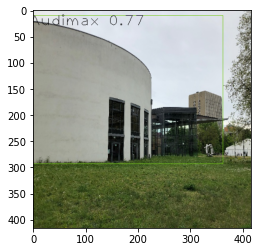

In [15]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))